![title](../images/header.png)

# Vb - Supervised Classification on national eSBAE trained with regional CAFI data
-------
this notebook performs a supervised classification of probability of forest change for one country using the regional merged eSBAE and CEO data trained on the interpreted data from CAFI DDD phase I (2015-2020) - output from script 5a.  
The change probability is then divided into any number of strata using kmeans
The modeled data are exported to csv for the following script to extract samples for validation in CEO.

This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling


import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.10/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


### Parameters

In [2]:
ISO = 'CAR'

In [3]:
# number of strata
strata = 3

#### Import the CEO validated data to train the model 
##### this is output from script 5a which can be downloaded from https://github.com/aurelgrooves/CAFI_DDD

In [4]:
trn_ceo = pd.read_csv('/home/sepal-user/module_results/esbae/CAFI/CAFI_esbae_ceo_phaseI_merge.csv', delimiter=',')
trn_ceo.head()

,geometry,UniqueID,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,...,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Defall,Degall,Stable,NF,sampling
0,POINT (25.60212043970481 -11.69188781696459),1,181,97,2018.589,-738.678406,-1.354781,2016.597,0.111200,45954.212113,...,0,0,1,0,0,0,1,0,0,str_random
1,POINT (19.01297815864469 6.4049412756433215),2,153,90,2016.381,-1332.806396,-1.765601,2020.038,0.318602,53800.048638,...,0,0,0,0,1,0,1,0,0,str_random
2,POINT (22.79182996908423 7.078408225947362),3,158,93,2016.915,-2419.585449,-2.557598,2020.003,0.116307,48050.450691,...,0,0,0,0,1,0,1,0,0,str_random
3,POINT (27.430102161958636 -6.534839348431254),4,129,60,-1.000,0.000000,0.000000,2017.430,0.290449,37411.044881,...,0,0,0,0,0,0,0,1,0,str_random
4,POINT (22.212146832136273 -9.940981656419584),5,140,79,2018.342,13.038783,-0.582325,2018.518,0.164515,32283.895600,...,0,0,0,0,0,0,0,1,0,str_random


In [5]:
print(trn_ceo.columns.values)

['geometry' 'UniqueID' 'images' 'mon_images' 'bfast_change_date'
 'bfast_magnitude' 'bfast_means' 'cusum_change_date' 'cusum_confidence'
 'cusum_magnitude' 'red_mean' 'red_sd' 'red_min' 'red_max' 'nir_mean'
 'nir_sd' 'nir_min' 'nir_max' 'swir1_mean' 'swir1_sd' 'swir1_min'
 'swir1_max' 'swir2_mean' 'swir2_sd' 'swir2_min' 'swir2_max' 'ndfi_mean'
 'ndfi_sd' 'ndfi_min' 'ndfi_max' 'brightness_mean' 'brightness_sd'
 'brightness_min' 'brightness_max' 'greenness_mean' 'greenness_sd'
 'greenness_min' 'greenness_max' 'wetness_mean' 'wetness_sd' 'wetness_min'
 'wetness_max' 'bs_slope_mean' 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min'
 'ewma_jrc_date' 'ewma_jrc_change' 'ewma_jrc_magnitude' 'mosum_jrc_date'
 'mosum_jrc_change' 'mosum_jrc_magnitude' 'cusum_jrc_date'
 'cusum_jrc_change' 'cusum_jrc_magnitude' 'ccdc_change_date'
 'ccdc_magnitude' 'aspect' 'dw_class_mode' 'dw_tree_prob__max'
 'dw_tree_prob__min' 'dw_tree_prob__stdDev' 'dw_tree_prob_mean'
 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17' 'es

In [6]:
trn_gdf = gpd.GeoDataFrame(trn_ceo, geometry=gpd.points_from_xy(trn_ceo.lon, trn_ceo.lat))

### Augmented dataset for country of interest
#### this is the output folder from eSBAE script 4 which is the data you want to classify

In [7]:
# glob all files in the data augmentation output folder
files = Path('/home/sepal-user/module_results/esbae/CAR/04_Dataset_Augmentation_2015_2022/Landsat/').glob('*geojson')

In [8]:
# output file eSBAE data for your country with a modeled change probability
all_points_out_file = '/home/sepal-user/module_results/esbae/CMR/CMR_esbae_1520_model.csv'

In [9]:
#eSBAE columns to include in data export
cols_to_export = ['geometry', 'UniqueID',
                  #'dates', 'ts',
                  'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope',
       'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020',
       'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub']

In [10]:
#parquet file to pick up mid script
parquet_out = '/home/sepal-user/module_results/esbae/CAR/CAR_esbae_1522_parquet'

#### end of parameters

# 1 - CEO data preparation
### 1.1 - Import CEO interpreted data

In [11]:
len(trn_gdf.index)

13115

### 1.2 - Inspect CEO interpreted data

Our ultimate goal is to use the CEO data for getting the probability of forest change via a series of classifications and their probability output. . , i.e. Forest-Non-Forest and a Change-No-Change classifcation.
Therefore we need to extract and trnasform the relevant information into a column of 0s and 1s. 

First let's look at the columns the CEO file contains.

In [12]:
trn_gdf.columns.tolist()

['geometry',
 'UniqueID',
 'images',
 'mon_images',
 'bfast_change_date',
 'bfast_magnitude',
 'bfast_means',
 'cusum_change_date',
 'cusum_confidence',
 'cusum_magnitude',
 'red_mean',
 'red_sd',
 'red_min',
 'red_max',
 'nir_mean',
 'nir_sd',
 'nir_min',
 'nir_max',
 'swir1_mean',
 'swir1_sd',
 'swir1_min',
 'swir1_max',
 'swir2_mean',
 'swir2_sd',
 'swir2_min',
 'swir2_max',
 'ndfi_mean',
 'ndfi_sd',
 'ndfi_min',
 'ndfi_max',
 'brightness_mean',
 'brightness_sd',
 'brightness_min',
 'brightness_max',
 'greenness_mean',
 'greenness_sd',
 'greenness_min',
 'greenness_max',
 'wetness_mean',
 'wetness_sd',
 'wetness_min',
 'wetness_max',
 'bs_slope_mean',
 'bs_slope_sd',
 'bs_slope_max',
 'bs_slope_min',
 'ewma_jrc_date',
 'ewma_jrc_change',
 'ewma_jrc_magnitude',
 'mosum_jrc_date',
 'mosum_jrc_change',
 'mosum_jrc_magnitude',
 'cusum_jrc_date',
 'cusum_jrc_change',
 'cusum_jrc_magnitude',
 'ccdc_change_date',
 'ccdc_magnitude',
 'aspect',
 'dw_class_mode',
 'dw_tree_prob__max',
 'dw_tr

In [13]:
trn_gdf['UniqueID'].nunique(dropna=False)

13115

### 1.3 Print unique values for columns of interest generate Change-No Change

In [14]:
# show unique values for the columns (in red)
print('Change', trn_gdf['Ref_Change_Type_1520'].unique())

Change ['Deg' 'Stable' 'NF' 'Def']


In [15]:
# add stable forest column for classification
trn_gdf['Change_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'Def' or  x == 'Deg' else 0)
np.unique(trn_gdf['Change_Bin'], return_counts=True)

(array([0, 1]), array([9275, 3840]))

In [16]:
# add stable forest column for classification
trn_gdf['Stable_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'Stable' else 0)
np.unique(trn_gdf['Stable_Bin'], return_counts=True)

(array([0, 1]), array([8446, 4669]))

In [17]:
# add def column for classification
trn_gdf['Def_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'Def' else 0)
np.unique(trn_gdf['Def_Bin'], return_counts=True)

(array([0, 1]), array([10574,  2541]))

In [18]:
# add def column for classification
trn_gdf['Deg_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'Deg' else 0)
np.unique(trn_gdf['Deg_Bin'], return_counts=True)

(array([0, 1]), array([11816,  1299]))

In [19]:
# add NF column for classification
trn_gdf['NF_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'NF' else 0)
np.unique(trn_gdf['NF_Bin'], return_counts=True)

(array([0, 1]), array([8509, 4606]))

In [20]:
trn_gdf.head()

,geometry,UniqueID,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,...,Defall,Degall,Stable,NF,sampling,Change_Bin,Stable_Bin,Def_Bin,Deg_Bin,NF_Bin
0,POINT (25.60212 -11.69189),1,181,97,2018.589,-738.678406,-1.354781,2016.597,0.111200,45954.212113,...,0,1,0,0,str_random,1,0,0,1,0
1,POINT (19.01298 6.40494),2,153,90,2016.381,-1332.806396,-1.765601,2020.038,0.318602,53800.048638,...,0,1,0,0,str_random,1,0,0,1,0
2,POINT (22.79183 7.07841),3,158,93,2016.915,-2419.585449,-2.557598,2020.003,0.116307,48050.450691,...,0,1,0,0,str_random,1,0,0,1,0
3,POINT (27.43010 -6.53484),4,129,60,-1.000,0.000000,0.000000,2017.430,0.290449,37411.044881,...,0,0,1,0,str_random,0,1,0,0,0
4,POINT (22.21215 -9.94098),5,140,79,2018.342,13.038783,-0.582325,2018.518,0.164515,32283.895600,...,0,0,1,0,str_random,0,1,0,0,0


In [21]:
# check for missing counts
# Initialize a dictionary to store the counts by column
merged_columns = trn_gdf.columns.tolist()
missing_counts = {}

# Count missing values and sum the counts by column
for column in merged_columns:
    missing_counts[column] =trn_gdf[column].isna().sum()

# Print the counts
print(missing_counts)

{'geometry': 0, 'UniqueID': 0, 'images': 0, 'mon_images': 0, 'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_ma

# 2 - Join CEO and Time-Series data

### 2.1 - Load data augmented time-series data from script 4
area must intersect with the CAFI region

In [22]:
# prepare for parallel execution
files = [[str(file), False] for file in files]

# read files in parallel nad put the in a list
result = py_helpers.run_in_parallel(
    py_helpers.geojson_to_gdf,
    files,
    workers=4,
    parallelization='processes'
)

# concatenate dataframes from result's list
cdf = pd.concat(result)

ValueError: No objects to concatenate

In [ ]:
#save file
cdf.to_parquet(parquet_out)

###### if you want to pick up script from here

In [23]:
#if you already ran this step you can read the parquet file
#cdf = gpd.read_parquet(parquet_out)

In [121]:
all_columns = cdf.columns.tolist()

# Print the list of columns
print(all_columns)

['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images', 'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tr

In [122]:
len(cdf.index)

394066

In [123]:
print(trn_gdf.columns)

Index(['geometry', 'UniqueID', 'images', 'mon_images', 'bfast_change_date',
       'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude',
       ...
       'Defall', 'Degall', 'Stable', 'NF', 'sampling', 'Change_Bin',
       'Stable_Bin', 'Def_Bin', 'Deg_Bin', 'NF_Bin'],
      dtype='object', length=132)


In [124]:
merged_columns = cdf.columns.tolist()
# Initialize a dictionary to store the counts by column
merged_columns = cdf.columns.tolist()
missing_counts = {}

# Count missing values and sum the counts by column
for column in merged_columns:
    missing_counts[column] =cdf[column].isna().sum()

# Print the counts
print(missing_counts)

{'geometry': 0, 'point_id': 0, 'dates': 0, 'ts': 0, 'images': 0, 'mon_images': 0, 'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_chan

### 2.2 - Make a union with training data

In [125]:
db = pd.concat([cdf, trn_gdf], ignore_index=True)

In [126]:
len(db.index)

407181

In [127]:
db.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,Defall,Degall,Stable,NF,sampling,Change_Bin,Stable_Bin,Def_Bin,Deg_Bin,NF_Bin
0,POINT (8.95545 5.77879),108803.0,"[20100104, 20100325, 20100410, 20101104, 20101...","{'green': [366.5934124898808, 2072.22530900619...",121,81,-1.000,0.000000,0.000000,2018.093,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (8.94542 5.77883),108777.0,"[20100104, 20101206, 20101222, 20110107, 20110...","{'green': [349.6845014132316, 380.791712420529...",109,78,2022.408,331.198334,0.416161,2021.005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (8.96053 5.76918),108830.0,"[20100104, 20100205, 20100325, 20100410, 20101...","{'green': [419.62363747288805, 854.51891671717...",127,94,2018.488,69.309608,-0.394872,2022.847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (11.56947 3.48036),103323.0,"[20100122, 20101208, 20101224, 20111125, 20111...","{'green': [799.7672378643781, 997.098125081312...",77,48,2019.348,100.008171,0.838891,2021.405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (11.57946 3.48036),103361.0,"[20100122, 20101122, 20101208, 20110109, 20111...","{'green': [1525.4683178058456, 3163.2491026601...",83,52,2018.011,-2219.533447,-2.458982,2023.970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
print(db.columns.values)

['geometry' 'point_id' 'dates' 'ts' 'images' 'mon_images'
 'bfast_change_date' 'bfast_magnitude' 'bfast_means' 'cusum_change_date'
 'cusum_confidence' 'cusum_magnitude' 'red_mean' 'red_sd' 'red_min'
 'red_max' 'nir_mean' 'nir_sd' 'nir_min' 'nir_max' 'swir1_mean' 'swir1_sd'
 'swir1_min' 'swir1_max' 'swir2_mean' 'swir2_sd' 'swir2_min' 'swir2_max'
 'ndfi_mean' 'ndfi_sd' 'ndfi_min' 'ndfi_max' 'brightness_mean'
 'brightness_sd' 'brightness_min' 'brightness_max' 'greenness_mean'
 'greenness_sd' 'greenness_min' 'greenness_max' 'wetness_mean'
 'wetness_sd' 'wetness_min' 'wetness_max' 'bs_slope_mean' 'bs_slope_sd'
 'bs_slope_max' 'bs_slope_min' 'ewma_jrc_date' 'ewma_jrc_change'
 'ewma_jrc_magnitude' 'mosum_jrc_date' 'mosum_jrc_change'
 'mosum_jrc_magnitude' 'cusum_jrc_date' 'cusum_jrc_change'
 'cusum_jrc_magnitude' 'ccdc_change_date' 'ccdc_magnitude' 'aspect'
 'dw_class_mode' 'dw_tree_prob__max' 'dw_tree_prob__min'
 'dw_tree_prob__stdDev' 'dw_tree_prob_mean' 'elevation' 'esa_lc20'
 'esa_lc21' '

In [129]:
len(cdf.index)+len(trn_gdf.index) == len(db.index)

True

#### check for NAs

In [130]:
# Initialize a dictionary to store the counts by column
missing_counts = {}

# Count missing values and sum the counts by column
for column in cols_to_export:
    missing_counts[column] = db[column].isna().sum()

# Print the counts
print(missing_counts)

{'geometry': 0, 'UniqueID': 394066, 'images': 0, 'mon_images': 0, 'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_j

In [131]:
# Specify the columns to replace NaN with 0 (categorical data)
columns_to_fill = ['gfc_lossyear', 'gfc_gain','gfc_loss', 'lang_tree_height', 'esa_lc20', 'esa_lc21', 'esri_lc20',  'esri_lc21' , 'esri_lc19', 'esri_lc18', 'esri_lc17', 
                   'potapov_tree_height','elevation','slope', 'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 'aspect']

# Set NaN values in the selected columns to 0
db[columns_to_fill] = db[columns_to_fill].fillna(0)

In [132]:
# Specify the columns you want to impute with the mean value - continuous data
columns_to_impute = ['dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__stdDev','dw_tree_prob_mean', 'dw_tree_prob__min']

# Impute NaN values in the selected columns with the mean
for column in columns_to_impute:
    mean_value = db[column].mean()
    db[column].fillna(mean_value, inplace=True)

### 2.4 Check the amount of ground truth data we have for each class

In [133]:
db['interpreted'].value_counts(dropna=False)

interpreted
NaN    394066
1.0     13115
Name: count, dtype: int64

In [134]:
db['Ref_FNF_2015'].value_counts(dropna=False)

Ref_FNF_2015
NaN    394066
1.0      8509
0.0      4606
Name: count, dtype: int64

In [135]:
db['Ref_Change_Year_1520'].value_counts(dropna=False)

Ref_Change_Year_1520
NaN        394066
Stable       4669
NF           4606
Def2017       765
Def2018       734
Def2016       539
Deg2017       440
Def2019       362
Deg2018       328
Deg2016       280
Deg2019       150
Def2020       141
Deg2020       101
Name: count, dtype: int64

In [136]:
db['Change_Bin'].value_counts(dropna=False)

Change_Bin
NaN    394066
0.0      9275
1.0      3840
Name: count, dtype: int64

## 3. Run change/no-change classification
#### create multiple models for type of change

In [137]:
# eSBAE columns for analysis
eSBAE_analysis = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    'images', 'mon_images', 
       'bfast_change_date','bfast_magnitude', 'bfast_means', 
       'cusum_change_date','cusum_confidence', 'cusum_magnitude', 
       'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope',
       'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020',
       'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub']

In [138]:
# predictors used change/nochange classification
db['chg_prob_cafi1520'] = clf.binary_probability_classification(db, 'Change_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.7855890202058712


In [139]:
# predictors used change/nochange classification
db['def_prob_cafi1520'] = clf.binary_probability_classification(db, 'Def_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.757910789172703


In [140]:
# predictors used change/nochange classification
db['deg_prob_cafi1520'] = clf.binary_probability_classification(db, 'Deg_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.6870758673274876


In [141]:
# predictors used change/nochange classification
db['stable_prob_cafi1520'] = clf.binary_probability_classification(db, 'Stable_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.8538314906595501


In [142]:
clf_db = db[db["point_id"] > 0]

array([<Axes: title={'center': 'chg_prob_cafi1520'}>], dtype=object)

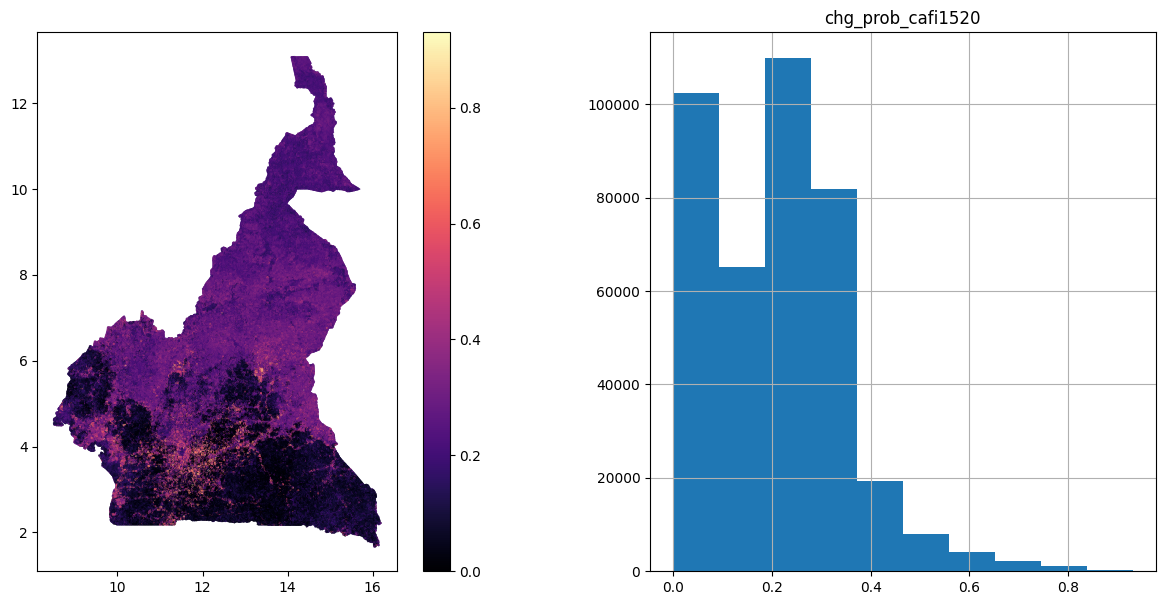

In [143]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('chg_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('chg_prob_cafi1520', ax=ax[1])

array([<Axes: title={'center': 'def_prob_cafi1520'}>], dtype=object)

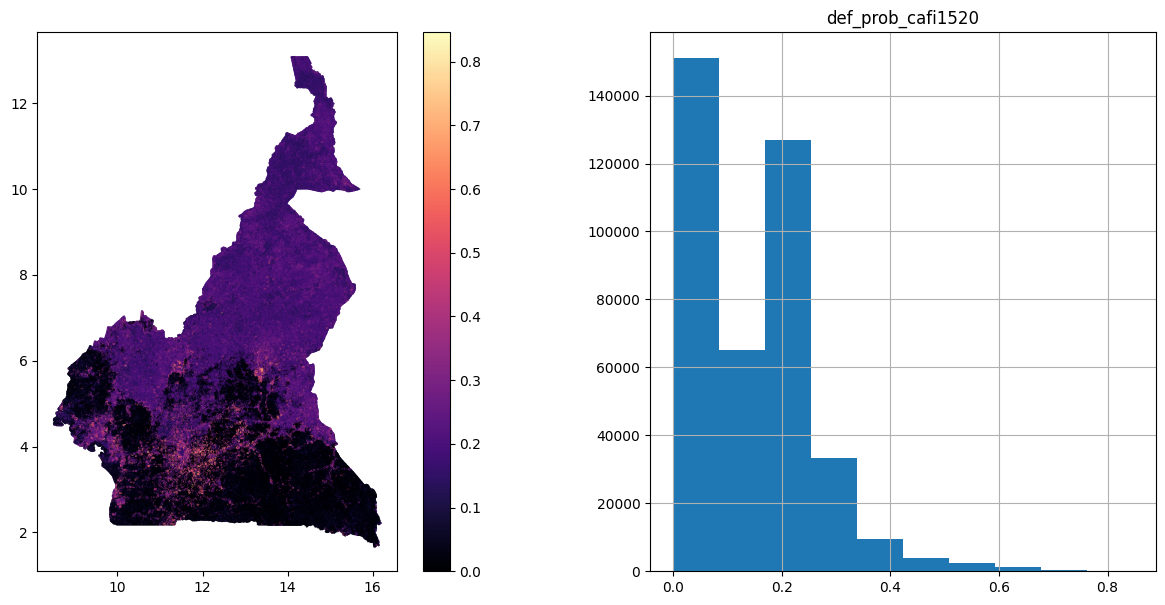

In [144]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('def_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('def_prob_cafi1520', ax=ax[1])

array([<Axes: title={'center': 'deg_prob_cafi1520'}>], dtype=object)

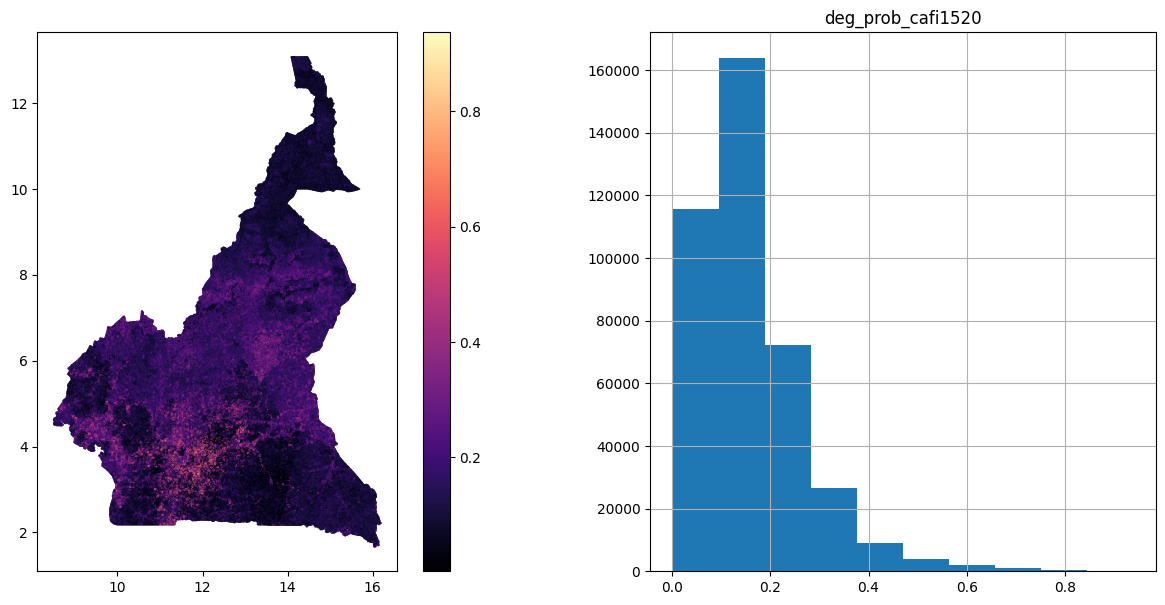

In [145]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('deg_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('deg_prob_cafi1520', ax=ax[1])

array([<Axes: title={'center': 'stable_prob_cafi1520'}>], dtype=object)

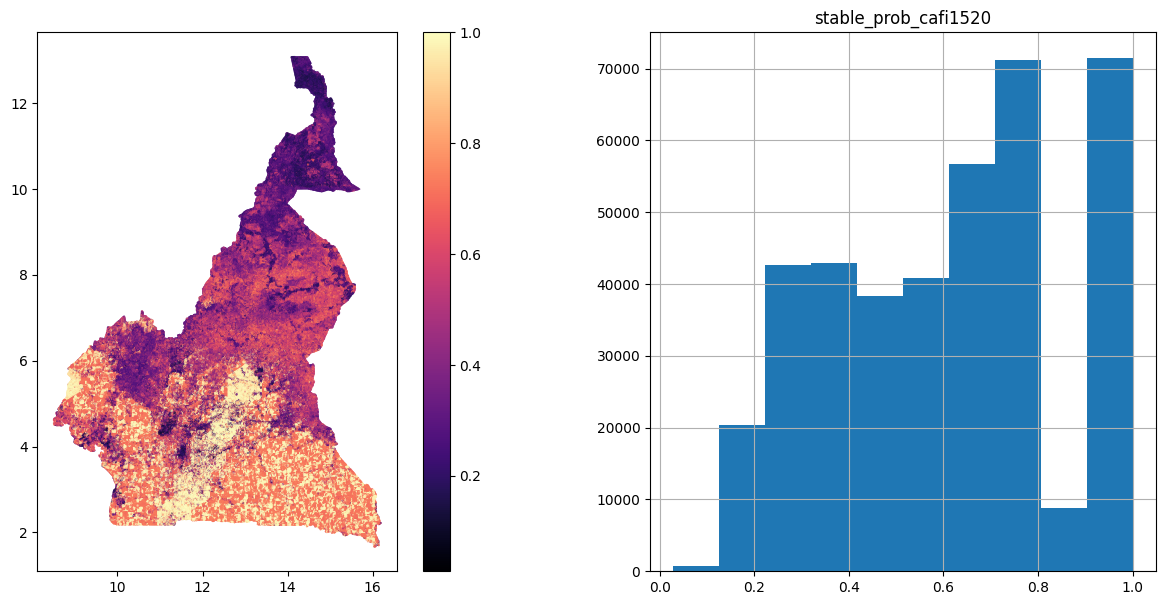

In [146]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('stable_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('stable_prob_cafi1520', ax=ax[1])

In [147]:
clf_db.columns

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date',
       ...
       'sampling', 'Change_Bin', 'Stable_Bin', 'Def_Bin', 'Deg_Bin', 'NF_Bin',
       'chg_prob_cafi1520', 'def_prob_cafi1520', 'deg_prob_cafi1520',
       'stable_prob_cafi1520'],
      dtype='object', length=141)

In [148]:
joined_df = clf_db

In [149]:
len(joined_df)

394066

### 3.2 Stratify with Kmeans

In [150]:
sample_size_no = 10000

In [151]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'chg_prob_cafi1520', strata=strata, sample_size=sample_size_no)

In [152]:
joined_df['kmeans_chg_1520'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
0,152770,0.071894,0.047936,7323.245999,1,3329,3876
1,209904,0.265307,0.053574,11245.490936,2,5112,5326
2,31392,0.497760,0.109158,3426.679620,3,1557,796


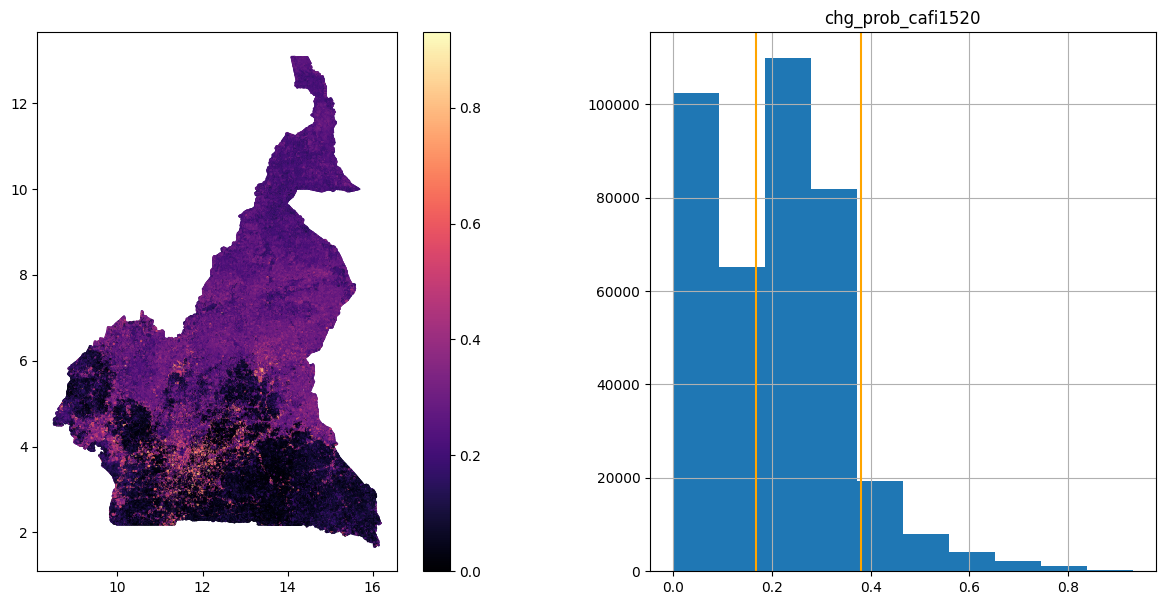

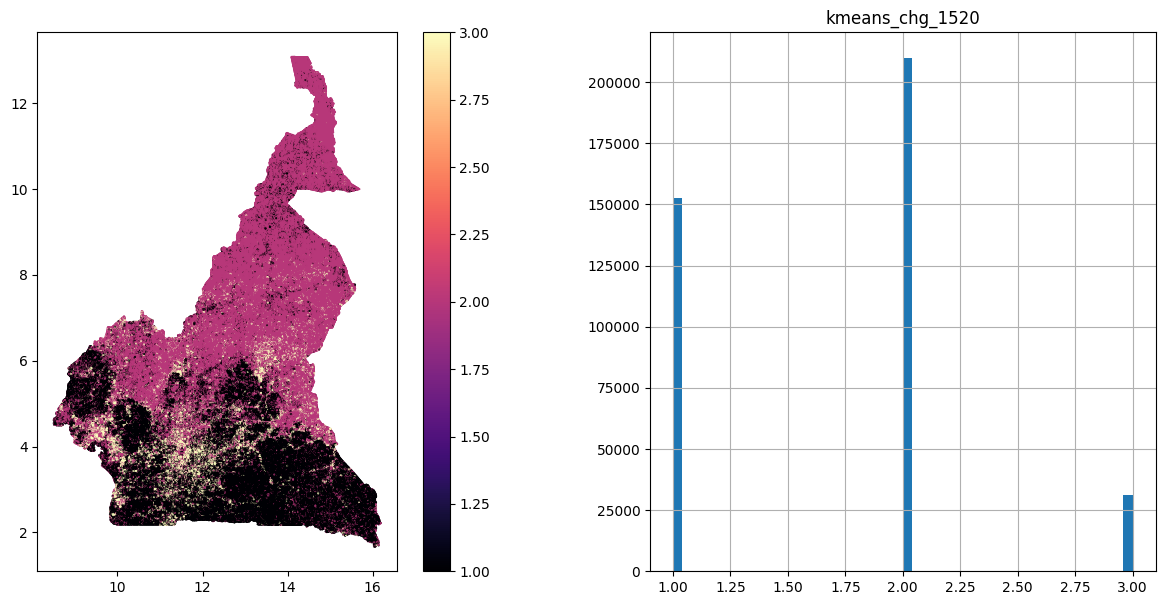

In [153]:
h.plot_cluster(joined_df, prob_column='chg_prob_cafi1520', strata_column='kmeans_chg_1520')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_chg_1520', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_chg_1520', ax=ax[1], bins=50)
samples

In [154]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'def_prob_cafi1520', strata=3, sample_size=sample_size_no)

In [155]:
joined_df['kmeans_def_1520'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
0,162295,0.031328,0.026772,4345.026031,1,2774,4118
2,206242,0.199677,0.042306,8725.240695,2,5572,5233
1,25529,0.405901,0.101374,2587.964185,3,1652,647


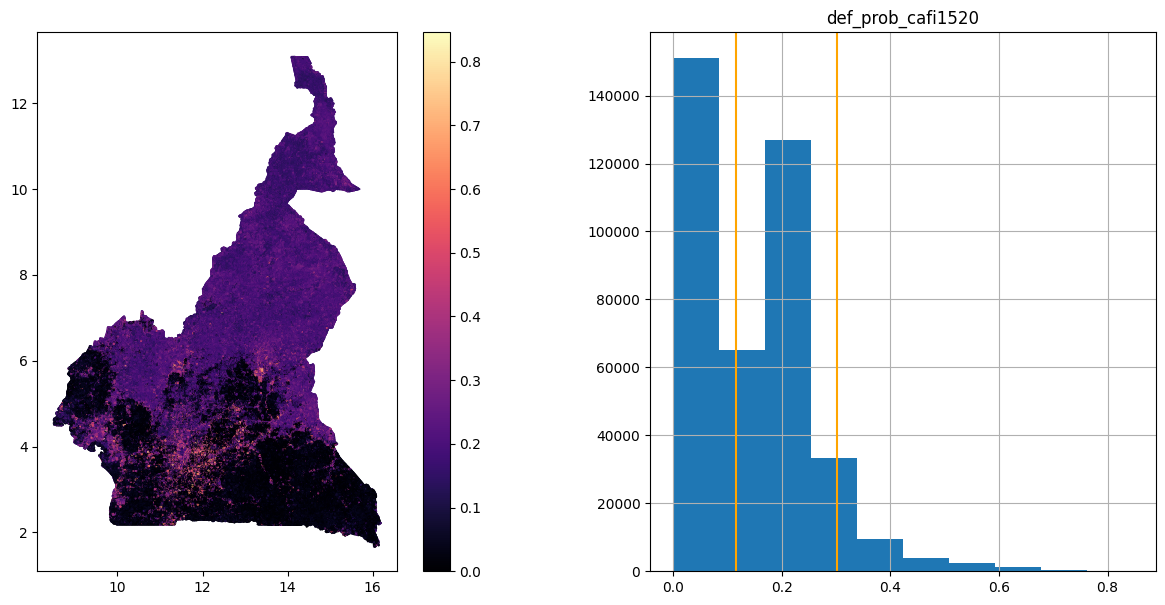

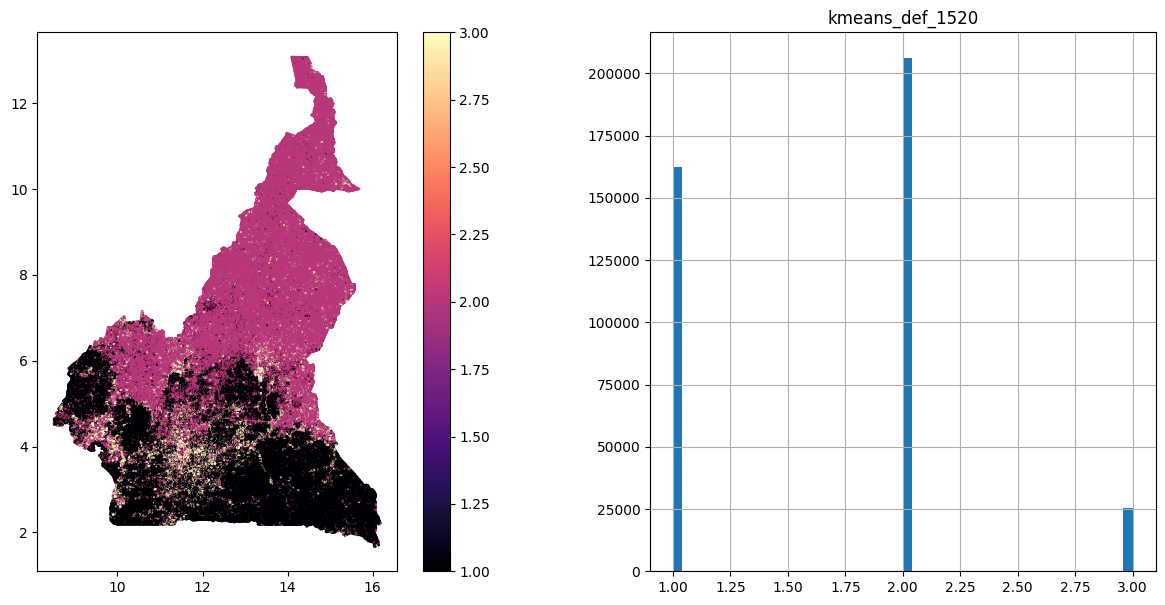

In [156]:
h.plot_cluster(joined_df, prob_column='def_prob_cafi1520', strata_column='kmeans_def_1520')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_def_1520', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_def_1520', ax=ax[1], bins=50)
samples

In [157]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'deg_prob_cafi1520', strata=3, sample_size=sample_size_no)

In [158]:
joined_df['kmeans_deg_1520'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
1,213850,0.091177,0.033629,7191.489415,1,4287,5426
0,146121,0.204748,0.041911,6124.103785,2,3651,3708
2,34095,0.404569,0.101384,3456.694873,3,2060,865


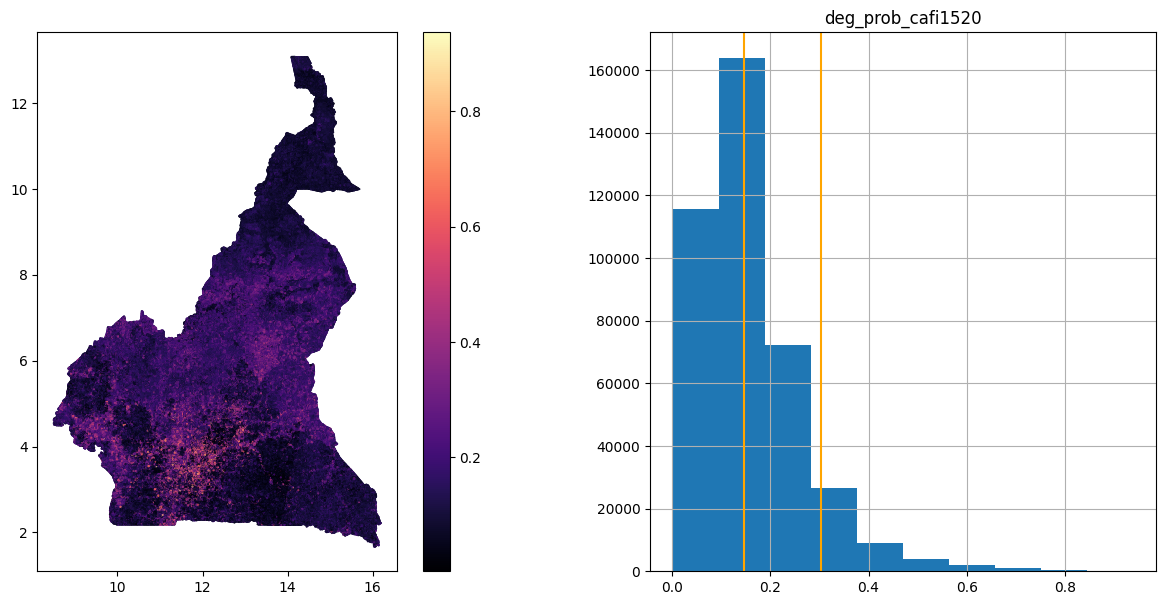

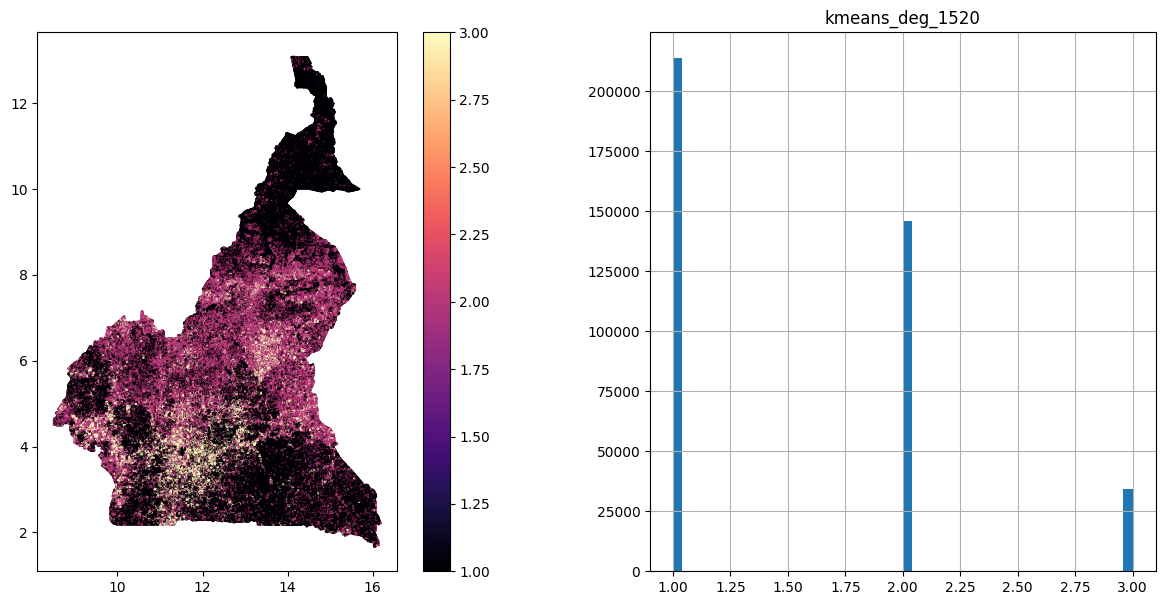

In [159]:
h.plot_cluster(joined_df, prob_column='deg_prob_cafi1520', strata_column='kmeans_deg_1520')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_deg_1520', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_deg_1520', ax=ax[1], bins=50)
samples

In [160]:
cross_tab = pd.crosstab(index= joined_df['kmeans_def_1520'], columns=joined_df['kmeans_deg_1520'], margins=True, margins_name="Total")
cross_tab

kmeans_deg_1520,1,2,3,Total
kmeans_def_1520,,,,
1,122877,36176,3242,162295
2,90008,101168,15066,206242
3,965,8777,15787,25529
Total,213850,146121,34095,394066


In [161]:
pd.pivot_table(joined_df,values='point_id',index=['kmeans_chg_1520'],aggfunc="count", margins=True)

,point_id
kmeans_chg_1520,
1,152770
2,209904
3,31392
All,394066


### 4. align column names, get coordinates


In [162]:
joined_df['PLOTID'] = joined_df['point_id']

In [163]:
joined_df.columns.tolist()

['geometry',
 'point_id',
 'dates',
 'ts',
 'images',
 'mon_images',
 'bfast_change_date',
 'bfast_magnitude',
 'bfast_means',
 'cusum_change_date',
 'cusum_confidence',
 'cusum_magnitude',
 'red_mean',
 'red_sd',
 'red_min',
 'red_max',
 'nir_mean',
 'nir_sd',
 'nir_min',
 'nir_max',
 'swir1_mean',
 'swir1_sd',
 'swir1_min',
 'swir1_max',
 'swir2_mean',
 'swir2_sd',
 'swir2_min',
 'swir2_max',
 'ndfi_mean',
 'ndfi_sd',
 'ndfi_min',
 'ndfi_max',
 'brightness_mean',
 'brightness_sd',
 'brightness_min',
 'brightness_max',
 'greenness_mean',
 'greenness_sd',
 'greenness_min',
 'greenness_max',
 'wetness_mean',
 'wetness_sd',
 'wetness_min',
 'wetness_max',
 'bs_slope_mean',
 'bs_slope_sd',
 'bs_slope_max',
 'bs_slope_min',
 'ewma_jrc_date',
 'ewma_jrc_change',
 'ewma_jrc_magnitude',
 'mosum_jrc_date',
 'mosum_jrc_change',
 'mosum_jrc_magnitude',
 'cusum_jrc_date',
 'cusum_jrc_change',
 'cusum_jrc_magnitude',
 'ccdc_change_date',
 'ccdc_magnitude',
 'aspect',
 'dw_class_mode',
 'dw_tree_pr

In [165]:
joined_df.drop(columns=(['dates','ts','stratum','UniqueID',
 'PLOTID', 'CEO_PLOTID','CEO_Ref_Code','lon','lat', 'Ref_FNF_2015',
 'Ref_LCover', 'Ref_Change_Type_1520', 'Ref_Year',
 'Source', 'Ref_Change_Year_1520',
 'Ref_Change_1520', 'collection', 'interpreted',
 'Def2016', 'Def2017','Def2018', 'Def2019',
 'Def2020', 'Deg2016', 'Deg2017', 'Deg2018',
 'Deg2019', 'Deg2020', 'Defall', 'Degall',
 'Stable', 'NF',]), inplace=True)

In [166]:
joined_df['LON'] = joined_df.geometry.apply(lambda p: p.x)
joined_df['LAT'] = joined_df.geometry.apply(lambda p: p.y)

### 5. export the points for your area with the change probability model

In [167]:
joined_df.to_csv(all_points_out_file,index=False)

### now you may proceed to script 5c if you want to extract sample points for CEO